# Revenue Forecasting with Prophet: Meta's ML Algorithm 

About this data set: This data is from 1C Company, a Russian software retailer known for its business enterprise software solutions and consumer video game distribution. It was accessed through Kaggle.

Link: https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data

*Goals*:
1. Forecast total sales revenue for the last two months of 2015.
2. Achieve a forecasting error that is superior to simple forecasting methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

plt.rcParams['figure.figsize'] = (10, 7.5)

## Reading & Cleaning Raw Data

### Reading Raw Data

In [2]:
df = pd.read_csv('sales_train.csv')
print(df.head(10))

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
5  10.01.2013               0       25     2564      349.00           1.0
6  02.01.2013               0       25     2565      549.00           1.0
7  04.01.2013               0       25     2572      239.00           1.0
8  11.01.2013               0       25     2572      299.00           1.0
9  03.01.2013               0       25     2573      299.00           3.0


### Cleaning Raw Data

*Cleaning Steps*:
1. Remove date_block_num (a consecutive month number) due to redundancy with date.
2. Remove shop_id and item_id due to the goal being total revenue not broken out revenue.
3. Modify all negative numbers in item_cnt_day to 0 because returns shouldn't impact sales revenue.
4. Calculate a new column sales_revenue by multiplying item_price and item_cnt_day then remove item_price and item_cnt_day.
5. Resample data to be grouped by day and sort oldest to newest.

In [3]:
df['date'] = pd.to_datetime(df['date'], format="%d.%m.%Y")

#1 & 2
df.drop(['date_block_num', 'shop_id', 'item_id'], axis=1, inplace=True)
df = df.set_index('date')

#3
copy = df['item_cnt_day'].copy()
item_cnt_day = []

for number in copy:
    if number < 0:
        number = 0
        item_cnt_day.append(number)
        continue
    item_cnt_day.append(number)
    
df.drop(['item_cnt_day'], axis=1, inplace=True)
df['item_cnt_day'] = item_cnt_day

#4
sales_revenue = df['item_price']*df['item_cnt_day']
df['sales_revenue'] = sales_revenue
df.drop(['item_price', 'item_cnt_day' ], axis=1, inplace=True)

#5
df = df[:].resample('D').sum()
df = df.reset_index()

## Reading & Characterizing Clean Data

In [4]:
df.head(2000)

,date,sales_revenue
0,2013-01-01,1371116.50
1,2013-01-02,6070414.01
2,2013-01-03,5460386.50
3,2013-01-04,4769843.50
4,2013-01-05,4600005.40
...,...,...
1029,2015-10-27,2266689.13
1030,2015-10-28,1726194.10
1031,2015-10-29,1860141.14
1032,2015-10-30,2623504.12


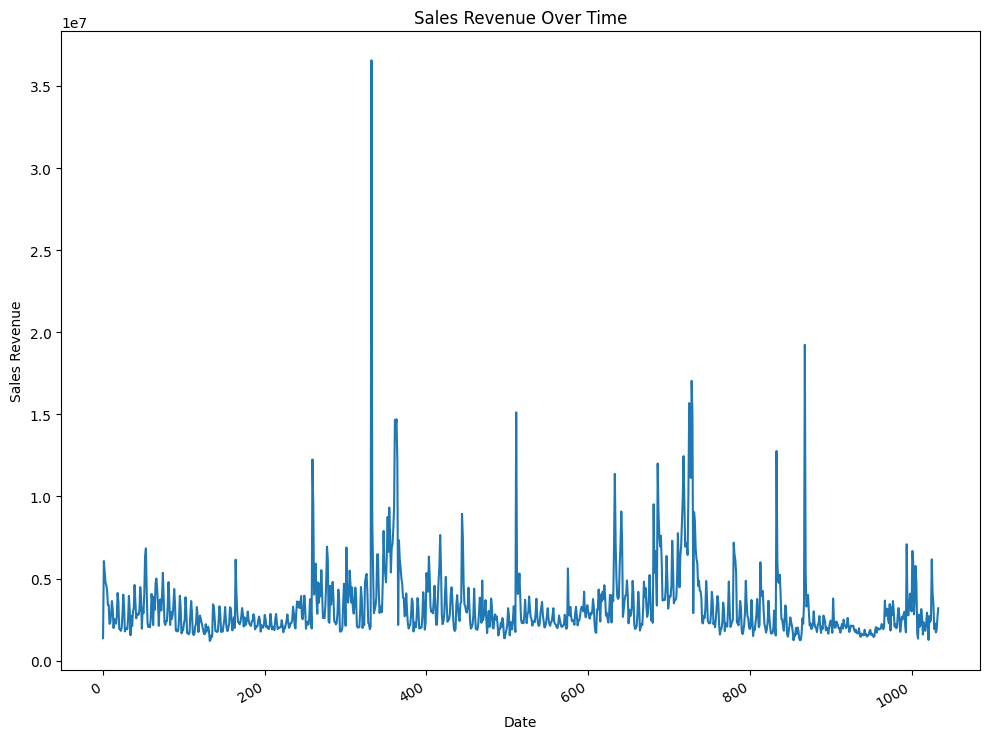

In [5]:
fig, ax = plt.subplots()
ax.plot(df.index, df.sales_revenue)


ax.set_xlabel('Date')
ax.set_ylabel('Sales Revenue')

ax.set_title('Sales Revenue Over Time')
fig.autofmt_xdate()
plt.tight_layout()

**From this figure, we see the time series has high variance with some spikes being seemingly random (the highest point over $35 million) while others have a seemingly cyclical build-up (the spike and build-up around days 380 and 720).**

<Axes: ylabel='Frequency'>

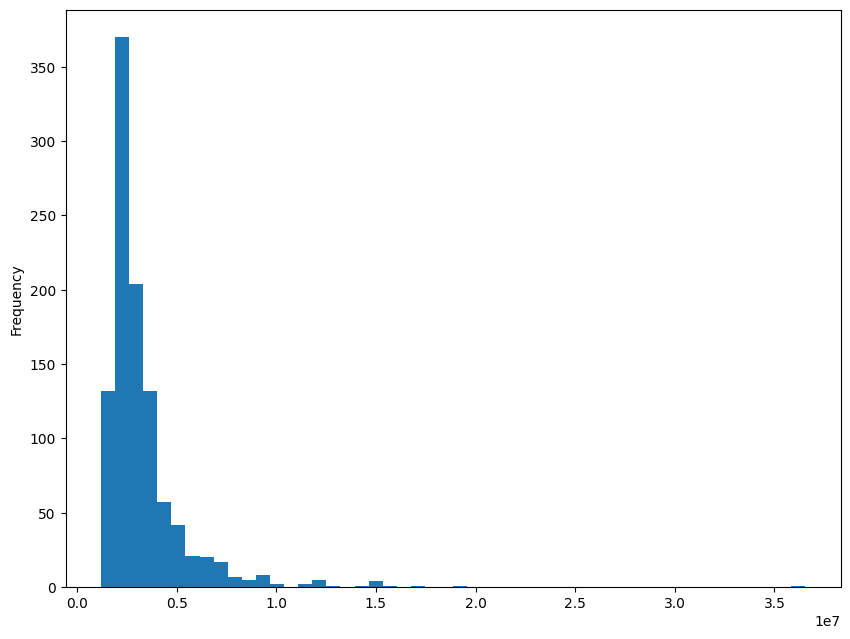

In [6]:
df['sales_revenue'].plot(kind='hist', bins=50)

**From this figure, we see the data has extreme right skew which could hinder the results of this model and increase the forecast error. Because of this, I considered removing outliers using the function below, however, I determined the data to be accurate and that by removing outliers I would be negatively impacting the predictive ability of this model. Therefore, I didn't remove outliers and simply identified them below.**

In [7]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

outliers = find_outliers_IQR(df['sales_revenue'])

print('number of outliers: '+ str(len(outliers)))
print('max outlier value: '+ str(outliers.max()))
print('min outlier value: '+ str(outliers.min()))
print(outliers)

#Uncomment below to test without statistical outliers
#df = df.query('sales_revenue < 6139227').copy()

number of outliers: 77
max outlier value: 36555221.00000549
min outlier value: 6139227.000000042
52      6.334179e+06
53      6.835117e+06
164     6.152369e+06
259     1.225504e+07
260     9.599832e+06
            ...     
833     1.276828e+07
868     1.923624e+07
994     7.090547e+06
1001    6.682603e+06
1025    6.167805e+06
Name: sales_revenue, Length: 77, dtype: float64


## Running Prophet with Defult Settings Values + Russian Holidays

By adding Russian holidays I hope to better capture sales seasonality, particularly in their consumer video game distribution division. Ultimately, this results in approximately 1% less forecast error (MAPE measurement).

In [8]:
df.columns = ['ds', 'y']

m = Prophet()
m.add_country_holidays(country_name='RU')
m.fit(df)
future = m.make_future_dataframe(periods=60)

22:19:49 - cmdstanpy - INFO - Chain [1] start processing
22:19:49 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
m.train_holiday_names

0              New Year Holidays
1                  Christmas Day
2      Fatherland Defender's Day
3      International Women's Day
4    Holiday of Spring and Labor
5                    Victory Day
6                     Russia Day
7                      Unity Day
dtype: object

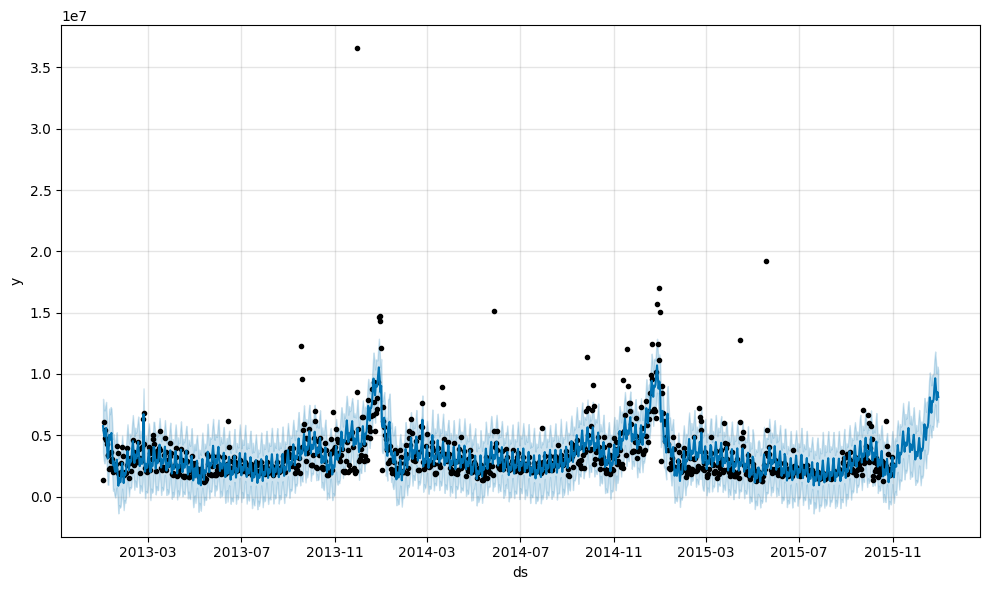

In [10]:
forecast = m.predict(future)
fig1 = m.plot(forecast)


**This figure shows the model looks relatively well fitted throughout and forecasts a build-up and peak in the last two months similar to the prior two years.**

In [11]:
print(round(sum(forecast['yhat'][-60:])))

295240009


**Based on this model sales revenue for the last two months would be approximately $295,240,009.**

### Running Cross Validation to Calculate Forecast Error

This model uses 80% of the time series (827 days) as a training set then tests on the remaining 20% (207 days), forecasting two months then advancing one month until it reaches the end of the time series. It then compares its forecasts to actual results and computes forecast error statistics.

In [12]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m, initial='827 days', period='30 days', horizon='60 days', parallel='processes')

df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-05-05,1.653875e+06,-662471.915914,3.964498e+06,1244987.36,2015-05-04
1,2015-05-06,1.396402e+06,-806283.891015,3.560282e+06,1604312.51,2015-05-04
2,2015-05-07,1.452044e+06,-723134.176987,3.702639e+06,1494919.34,2015-05-04
3,2015-05-08,2.350782e+06,186642.214754,4.500181e+06,1996551.06,2015-05-04
4,2015-05-09,3.094108e+06,745018.128421,5.323634e+06,1644502.83,2015-05-04


In [13]:
from prophet.diagnostics import performance_metrics

df_perf = performance_metrics(df_cv, rolling_window=1)
df_perf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,60 days,1.978717e+12,1.406669e+06,857491.176385,0.350024,0.307125,0.30136,0.966667


**The two key metrics I focus on are MAPE and coverage. I chose MAPE over MDAPE because MDAPE is much less sensitive to outliers and I have deemed outliers to be important, therefore, higher sensitivity is better. I chose MAPE over SMAPE because SMAPE favors overprediction compared to underpredictions and I want to treat both equally.**

**My MAPE of 35% indicates my model is 35% wrong comparied to actual historical results. My coverage of 96.7% indicates my confidence interval (80%) had the actual result within it 96.7% of the time.**

## Optimizing Prophet Settings Values Using Hyperparameter Optimization

The code below checks all 64 combinations of the three settings and prints the settings values that achieve the lowest MAE measurement. I am optimizing towards MAE instead of MAPE because it gives better results. This shouldn't be an issue because MAPE is just MAE expressed in a percent.

In [22]:
from itertools import product

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
} #

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

mae = []

for params in all_params:
    m = Prophet(**params).fit(df)
    df_cv = cross_validation(m, initial='827 days', period='30 days', horizon='60 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mae.append(df_p['mae'].values[0])
    
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = mae

import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

print(tuning_results)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                     0.01                  0.01   
1                     0.001                     0.01                  0.10   
2                     0.001                     0.01                  1.00   
3                     0.001                     0.01                 10.00   
4                     0.001                     0.10                  0.01   
..                      ...                      ...                   ...   
59                    0.500                     1.00                 10.00   
60                    0.500                    10.00                  0.01   
61                    0.500                    10.00                  0.10   
62                    0.500                    10.00                  1.00   
63                    0.500                    10.00                 10.00   

             mae  
0   1.354167e+06  
1   1.354167e+06  
2   1.

In [15]:
best_params = all_params[np.argmin(mae)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01}


## Running Prophet with Optimized Settings Values + Russian Holidays

22:21:04 - cmdstanpy - INFO - Chain [1] start processing
22:21:04 - cmdstanpy - INFO - Chain [1] done processing


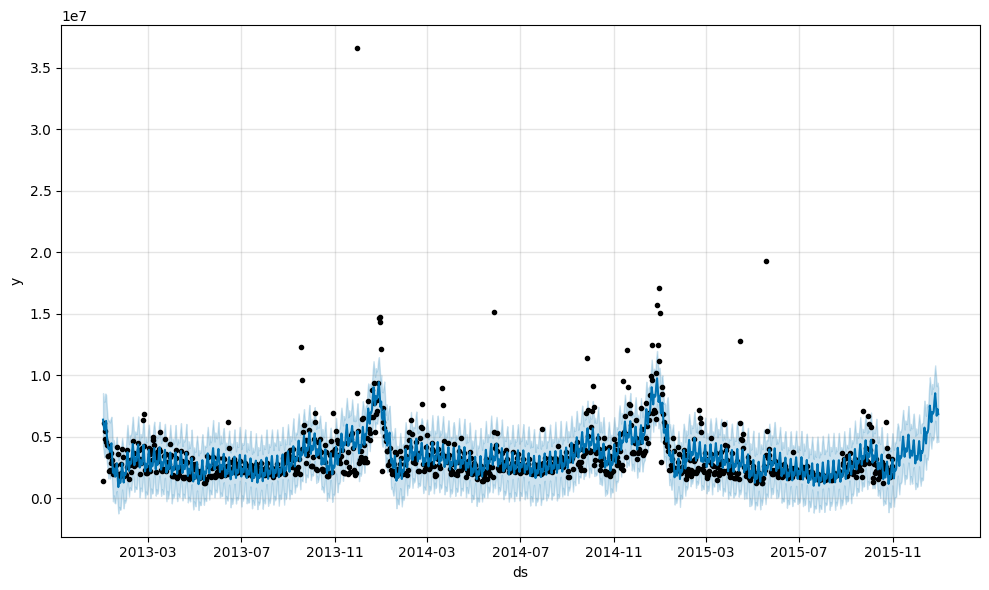

In [16]:
m = Prophet(changepoint_prior_scale = 0.1, seasonality_prior_scale = 0.01, holidays_prior_scale = 0.01) #Manually update from above
m.add_country_holidays(country_name='RU')

forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

In [17]:
print(round(sum(forecast['yhat'][-60:])))

273250549


**Based on this model sales revenue for the last two months would be approximately \\$273,250,549. This is $21,989,460 lower than the previous forecast.**

In [18]:
df_cv = cross_validation(m, initial='827 days', period='30 days', horizon='60 days', parallel='processes')

df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-05-05,1.707360e+06,-619496.471268,3.920721e+06,1244987.36,2015-05-04
1,2015-05-06,1.474384e+06,-994480.645275,3.655846e+06,1604312.51,2015-05-04
2,2015-05-07,1.532463e+06,-754786.082693,3.785956e+06,1494919.34,2015-05-04
3,2015-05-08,2.398794e+06,133032.984266,4.430095e+06,1996551.06,2015-05-04
4,2015-05-09,3.044142e+06,755549.387863,5.256322e+06,1644502.83,2015-05-04


In [19]:
df_perf = performance_metrics(df_cv, rolling_window=1)
df_perf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,60 days,1.824776e+12,1.350843e+06,756872.719515,0.300224,0.263082,0.273784,0.966667


**My MAPE of 30% is a 5% improvement over the previous forecast with the coverage staying the same.**